In [1]:
# Please email macw@cmu.edu to gain access to the Pitt corpus from DementiaBank. Made by Andi Liu

# Preprocessing

In [2]:
import pandas as pd
import zipfile
import io

import re
import numpy as np\

from collections import Counter
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy import stats
from researchpy import ttest as rp
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = []

zip_filename = 'Pitt.zip'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    cha_files = [file for file in zip_ref.namelist() if file.endswith('.cha')]

    for file_name in cha_files:
        with zip_ref.open(file_name) as file:
            lines = io.TextIOWrapper(file, 'utf-8', newline='', line_buffering=True).readlines()

        participant_id = None
        transcript = []
        patient_data = None

        for line in lines:
            if line.startswith('@ID:') and 'PAR' in line: 
                if participant_id and transcript:
                    data.append({'Participant ID': participant_id, 'Transcript': ' '.join(transcript), 'Patient Data': patient_data, 'File Name': file_name})
                    transcript = []
                participant_id = line.strip().split()[-1]
                patient_data = line.strip() 
            elif line.startswith('*'):
                transcript.append(line.strip())

        if participant_id and transcript:
            data.append({'File Name': file_name,'Patient Demographic': patient_data, 'Transcript': ' '.join(transcript)})


pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(data)

def process_transcript(text):
    return re.sub(r'(\w+)\s*:\[(\w+)]', r'[\2]', text)

In [4]:
def extract_word_after_format(text):
    pattern = r'\w+\s+\[: ([^\]]+?)\]'
    replacement = r'\1'
    return re.sub(pattern, replacement, text)

df['Transcript'] = df['Transcript'].apply(extract_word_after_format)

In [5]:
df['Transcript'] = df['Transcript'].str.replace(r'&\+hp|&\+s|&\+c|&\+wa|&\+m|&\+w|&\+t|&\+a|&\+prob|&\+house|&\+k|&\+fauc|&\+r|&\+pa|&\+th|&\+sh|&\+y|&\+diffi|&\+ree|&\+laun|&\+het|&\+fri|&\+liv|&\+op|&\+des|&\+go|&\+i|&\+ha', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'&=laughs|&=mumbles', '', regex=True)


In [6]:
df['Transcript'] = df['Transcript'].str.replace(r'\[* p:n\]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* p:n]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* s:r]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* s:uk]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* n:uk]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'&-(um|uh)\b', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'[^\w\s\.,?!;]', '', regex=True)# remove punctuation expect .,!?;
df['Transcript'] = df['Transcript'].str.replace(r'[\d_]', '') # remove numbers and underscores
df['Transcript'] = df['Transcript'].str.replace(r'INV.*?PAR', '', regex=True) # remove interviewer dialoge
df['Transcript'] = df['Transcript'].str.replace(r'PAR\t', '', regex=True)# remove PAR tag
df['Transcript'] = df['Transcript'].str.replace(r'\t', '', regex=True)# remove /t tag
df['Transcript'] = df['Transcript'].str.replace(r'xxx', '', regex=True)# remove xxx
df['Transcript'] = df['Transcript'].str.replace(r'exc', '', regex=True)# remove exe

C:\Users\kaiso\AppData\Local\Temp\ipykernel_20600\33270281.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Transcript'] = df['Transcript'].str.replace(r'[\d_]', '') # remove numbers and underscores


In [7]:
def remove_words_after_inv(text):
    pattern = r'INV.*'
    replaced_text = re.sub(pattern, 'INV ', text)
    return replaced_text

df['Transcript'] = df['Transcript'].apply(remove_words_after_inv)
df['Transcript'] = df['Transcript'].str.replace(r'INV\t', '', regex=True)

In [8]:
df['Transcript'] = df['Transcript'].str.replace(r'\bINV\b', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\b&=coughs\b', '', regex=True)

In [9]:
pd.set_option('display.html.use_mathjax', False)

In [10]:
regex_dementia = r'Pitt/Dementia/cookie/'
regex_control = r'Pitt/Control/cookie/'


df['File Name'] = df['File Name'].str.replace(regex_dementia, '', regex=True)
df['File Name'] = df['File Name'].str.replace(regex_control, '', regex=True)


In [11]:
#MSS score
regex_last_number = r'(\d{2})(?=[^\d]*$)'

df['MSS Score'] = df['Patient Demographic'].str.extract(regex_last_number)

In [12]:
#Age
regex_last_number = r'\|(\d{2})(?=;|\.\|)'

df['Age'] = df['Patient Demographic'].str.extract(regex_last_number)

In [13]:
#id
regex_last_number = r'(\d{3})'

df['id'] = df['File Name'].str.extract(regex_last_number)

In [14]:
#meet number
pattern = r'-(\d+)\.cha'

df['Meet Num'] = df['File Name'].str.extract(pattern)
df['Meet Num'] = pd.to_numeric(df['Meet Num'])

In [15]:
duplicates = df.duplicated(subset=['id'], keep=False)

if duplicates.any():
    print("There are rows with the same value in column 'A':")
    print(df[duplicates])
else:
    print("There are no rows with the same value in column 'A'.")

There are rows with the same value in column 'A':
     File Name                                         Patient Demographic  \
1    007-3.cha  @ID:\teng|Pitt|PAR|75;|female|ProbableAD||Participant|15||   
2    001-0.cha    @ID:\teng|Pitt|PAR|57;|male|ProbableAD||Participant|18||   
4    134-0.cha  @ID:\teng|Pitt|PAR|77;|female|ProbableAD||Participant|24||   
5    057-1.cha  @ID:\teng|Pitt|PAR|84;|female|ProbableAD||Participant|24||   
6    356-1.cha  @ID:\teng|Pitt|PAR|58;|female|ProbableAD||Participant|18||   
..         ...                                                         ...   
544  056-4.cha      @ID:\teng|Pitt|PAR|78;00.|male|Control||Participant|||   
545  015-2.cha     @ID:\teng|Pitt|PAR|68;|female|Control||Participant|30||   
546  128-3.cha     @ID:\teng|Pitt|PAR|73;|female|Control||Participant|29||   
547  132-0.cha       @ID:\teng|Pitt|PAR|58;|male|Control||Participant|30||   
548  140-0.cha     @ID:\teng|Pitt|PAR|58;|female|Control||Participant|30||   

             

In [16]:
demo = pd.read_csv("PItt-demo.csv")

demo.columns = demo.iloc[1] 
demo = demo.drop(df.index[1])
demo = demo.drop(df.index[0])

In [17]:
df['id'] = df['id'].astype(str).str.lstrip('0')

demo['id'] = demo['id'].astype(str).str.lstrip('0')

df1 = pd.merge(df, demo, on='id', how='outer')

In [18]:
df1 = df1.dropna(subset=['File Name'])

df1.reset_index(drop=True, inplace=True)

In [19]:
df1.loc[df1['MSS Score'] == '00', 'MSS Score'] = 'na'

In [23]:
df1 = df1.dropna(subset=['File Name'])
columns_to_keep = ['File Name', 'id', 'Transcript', 'MSS Score', 'Age', 'educ', 'sex','race', 'onsetage', 'basedx', 'dx2','Meet Num']

df = df1[df1.columns.intersection(columns_to_keep)]
df['Transcript'] = df['Transcript'].str.replace('gram', '')
#df.head()

C:\Users\kaiso\AppData\Local\Temp\ipykernel_20600\2424404988.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Transcript'] = df['Transcript'].str.replace('gram', '')


In [24]:
df = df.sort_values(by=['id', 'Meet Num'], ascending=[True, False])
df = df.drop_duplicates(subset='id', keep='first')
df = df.reset_index(drop=True)

duplicated_ids = df[df.duplicated(subset='id', keep=False)]

if not duplicated_ids.empty:
    print("Rows with the same id found:")
    print(duplicated_ids)
else:
    print("No rows with the same id found.")

print("\nDataFrame after reindexing:")

No rows with the same id found.

DataFrame after reindexing:


In [25]:
#Total word count
def count_total_words(sentence):
    if isinstance(sentence, str):
        
        words = sentence.split()
        return len(words)
    else:
        return 0  

df['Total Word Count'] = df['Transcript'].apply(count_total_words)

#Unique words

def count_unique_words(text):
    words = text.split()
    word_counts = Counter(words)
    unique_word_count = sum(1 for word, count in word_counts.items() if count == 1)
    return unique_word_count
df['Unique_Word_Count'] = df['Transcript'].apply(count_unique_words)
#TTR

df['TTR'] = df['Unique_Word_Count']/df['Total Word Count']

In [26]:
df = df[df['basedx'].isin(['1', '8'])]

df.reset_index(drop=True, inplace=True)

In [27]:
df = df[df['race'] != '2']
df.reset_index(drop=True)

,File Name,Transcript,MSS Score,Age,id,Meet Num,basedx,dx2,onsetage,sex,race,educ,Total Word Count,Unique_Word_Count,TTR
0,001-2.cha,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,1,NaN,54,1,1,14,122,40,0.327869
1,010-4.cha,kids are trying to get a ... its full of its full of mistakes . its full of mistakes . its full of mistakes . hes changing surret taking cookie jar . thats all . the mothers just drying the dishes . n n n n n n n from the from . this is ...,na,70,10,4.0,1,730,63,1,1,12,56,20,0.357143
2,105-2.cha,what do I tell you when I see it ? as I see it ? is there something going on here or ..? oh its just ... well the first bad thing I see is the water running outof the and the little boy up stealing cookies and giving one to his and mamas drying the dishes and standing in the water . shes looking the other direction . and the little boys falling off the stool standing up on hes gonna get hurt . when he hits that sink . like an airplane going crazy . hmhunh no . . you can see out the window . out into the yard . and you can see a window over there on the other side of the,na,58,105,2.0,8,-2,56,0,1,20,127,56,0.440945
3,109-4.cha,the boy is taking cookies . the girl is is saying . quiet . hes hes the boy is falling off the stool . the mother is drying dishes . the water is running over the sink . the curtains are blowing in the breeze . hm hm hm . the girl is putting her hand up to have him pass the cookies . shes drying the dishes . the waters running over . its splashing on the floor . . well the windows open but thats not action . thats the curtain blowing right ? I guess thats it . hes passing her the cookies . did I say that ? and hes taking them out of the jar .,30,64,109,4.0,8,-2,60,0,1,12,121,44,0.363636
4,113-3.cha,little boy getting in the cookie jar . and the little girl holding out her hand for some cookies . and a stool the boy is on is about to tip over . and a lady is drying a dish . and the water is running over overflowing from the sink . you said just the action ? the lady is stepping in the water on the floor . hm I dont know whats going on outside the window .,30,50,113,3.0,8,-2,47,0,1,14,80,36,0.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,092-3.cha,"the girls reaching for a cookie . the boy is reaching in the cookie jar . hes standing on the stool . the stool is tipping over . sho the girl with her finger to her mouth . the mother is drying a dish . the sink is overflowing with water . the things that are doing, not things that are going on ? thats it .",na,65,92,3.0,8,-2,62,0,1,12,67,26,0.388060
235,093-1.cha,well I see the mother doing the dishes . the sink the water running over in the sink . the boys taking cookies from the cookie jar . and he l the stool is falling over . and the little girl has her hands up to her mouth in other words to and the stools falling . yeah thats it . she has her hand up for him to pass her a cookie then be quiet . mothers ... the dishes in the sink . yeah okay .,28,65,93,1.0,8,NaN,64,0,1,12,88,37,0.420455
236,094-3.cha,mother son and daughter . the waters spilling outof the sink . . shes drying the dishes . the the kids are into the cookie jar . am I going too fast ? how many you got ? how many you need ? oh . you got the water running over . and the little boys gonna fall because its already what thing hes standing on . cir stool . is that all ?,na,76,94,3.0,1,NaN,70,0,1,12,74,42,0.567568
237,096-2.cha,what do I see going on ? just just start to describe it ? the girl

In [28]:
def keep_first_150_words(text):
    words = text.split()[:150]
    return ' '.join(words)

df['Transcript'] = df['Transcript'].apply(keep_first_150_words)

In [29]:
df_basedx_8 = df[df['basedx'] == '8']

max_TTR_basedx_8 = df_basedx_8['educ'].max()

print("Maximum value of 'TTR' in rows with basedx=8:", max_TTR_basedx_8)

Maximum value of 'TTR' in rows with basedx=8: 21


# outliers

In [30]:
df['z_score'] = stats.zscore(df['TTR'])

df = df[abs(df['z_score']) <= 3.0]
#df = df.drop(columns=['z_score'])

# Age and education matching

In [32]:
df['Age'] = df['Age'].astype(int)

In [36]:
ad = df[df['basedx'] == '1']['educ']
hc = df[df['basedx'] == '8']['educ']


huh = rp(ad, hc, equal_variances=False)
huh

C:\Users\kaiso\AppData\Roaming\Python\Python310\site-packages\researchpy\ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0      educ   61.0  12.934426  2.308454  0.295567  12.343204  13.525649
 1      educ   62.0  13.709677  2.391152  0.303677  13.102438  14.316916
 2  combined  123.0  13.325203  2.372990  0.213965  12.901638  13.748769,
           Satterthwaite t-test   results
 0  Difference (educ - educ) =    -0.7753
 1        Degrees of freedom =   120.9573
 2                         t =    -1.8294
 3     Two side test p value =     0.0698
 4    Difference < 0 p value =     0.0349
 5    Difference > 0 p value =     0.9651
 6                 Cohen's d =    -0.3298
 7                 Hedge's g =    -0.3278
 8            Glass's delta1 =    -0.3358
 9          Point-Biserial r =    -0.1641)

In [37]:
df['Age'] = df['Age'].astype(int)
ad = df[df['basedx'] == '1']['Age']
hc = df[df['basedx'] == '8']['Age']


huh = rp(ad, hc, equal_variances=False)
huh

C:\Users\kaiso\AppData\Roaming\Python\Python310\site-packages\researchpy\ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0       Age   61.0  70.049180  7.761929  0.993813  68.061258  72.037103
 1       Age   62.0  68.467742  6.390869  0.811641  66.844765  70.090719
 2  combined  123.0  69.252033  7.119119  0.641909  67.981309  70.522756,
         Satterthwaite t-test   results
 0  Difference (Age - Age) =     1.5814
 1      Degrees of freedom =   115.9803
 2                       t =     1.2325
 3   Two side test p value =     0.2203
 4  Difference < 0 p value =     0.8899
 5  Difference > 0 p value =     0.1101
 6               Cohen's d =     0.2226
 7               Hedge's g =     0.2212
 8          Glass's delta1 =     0.2037
 9        Point-Biserial r =     0.1137)

In [52]:
bru = df[(df['sex'] == '0')]

# Count the number of rows in the filtered DataFrame
count = len(bru)

# Print the result
print(bru)

Number of rows where 'basedx' and 'sex' are both 1: 73


In [38]:
ad = df[df['basedx'] == '1']['TTR']
hc = df[df['basedx'] == '8']['TTR']


huh = rp(ad, hc, equal_variances=False)
huh

C:\Users\kaiso\AppData\Roaming\Python\Python310\site-packages\researchpy\ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0       TTR   61.0  0.373267  0.108395  0.013879   0.345505  0.401028
 1       TTR   62.0  0.463747  0.085791  0.010895   0.441960  0.485533
 2  combined  123.0  0.418874  0.107339  0.009678   0.399715  0.438034,
         Satterthwaite t-test   results
 0  Difference (TTR - TTR) =    -0.0905
 1      Degrees of freedom =   114.1135
 2                       t =    -5.1280
 3   Two side test p value =     0.0000
 4  Difference < 0 p value =     0.0000
 5  Difference > 0 p value =     1.0000
 6               Cohen's d =    -0.9265
 7               Hedge's g =    -0.9208
 8          Glass's delta1 =    -0.8347
 9        Point-Biserial r =    -0.4328)

In [39]:
####dfrhfj
classes = df['basedx'].unique()

for class_label in classes:
    class_data = df.loc[df['basedx'] == class_label, 'TTR']
    
    
    statistic, p_value = shapiro(class_data)
    
    
    print(f"Class: {class_label}")
    print(f"Shapiro-Wilk Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

Class: 1
Shapiro-Wilk Test Statistic: 0.9695
P-value: 0.1315
Class: 8
Shapiro-Wilk Test Statistic: 0.9828
P-value: 0.5360


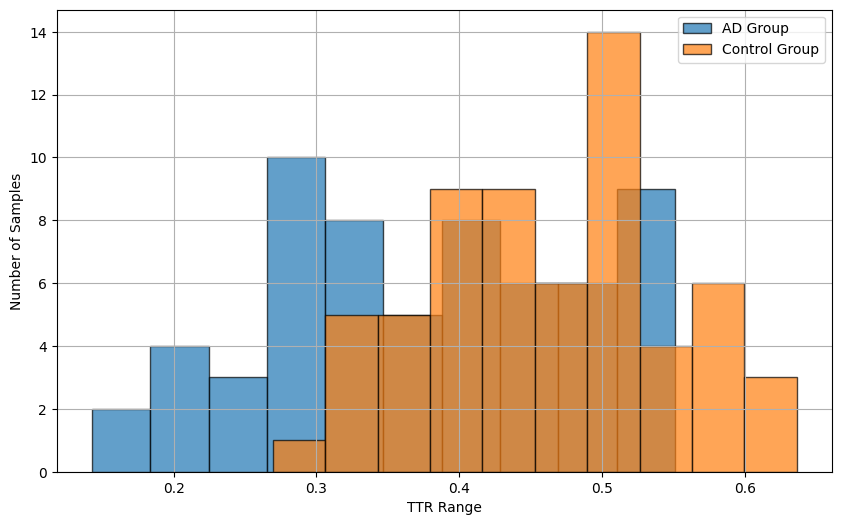

In [40]:
import matplotlib.pyplot as plt
ad_ddf = df[df['basedx'] == '1']
#ad_ddf = ad_ddf[abs(df['z_score']) <= 2.5]
control_ddf = df[df['basedx'] == '8']


plt.figure(figsize=(10, 6))


plt.hist(ad_ddf['TTR'], bins=10, edgecolor='black', alpha=0.7, label='AD Group')


plt.hist(control_ddf['TTR'], bins=10, edgecolor='black', alpha=0.7, label='Control Group')


plt.xlabel('TTR Range')
plt.ylabel('Number of Samples')
#plt.title('Type Token Ratio Comparison')
plt.grid(True)

plt.legend()
plt.show()

C:\Users\kaiso\AppData\Local\Temp\ipykernel_20600\1597564020.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x='basedx', y='mean_TTR', data=summary, palette='coolwarm', ci=None, width=0.4)
C:\Users\kaiso\AppData\Local\Temp\ipykernel_20600\1597564020.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='basedx', y='mean_TTR', data=summary, palette='coolwarm', ci=None, width=0.4)


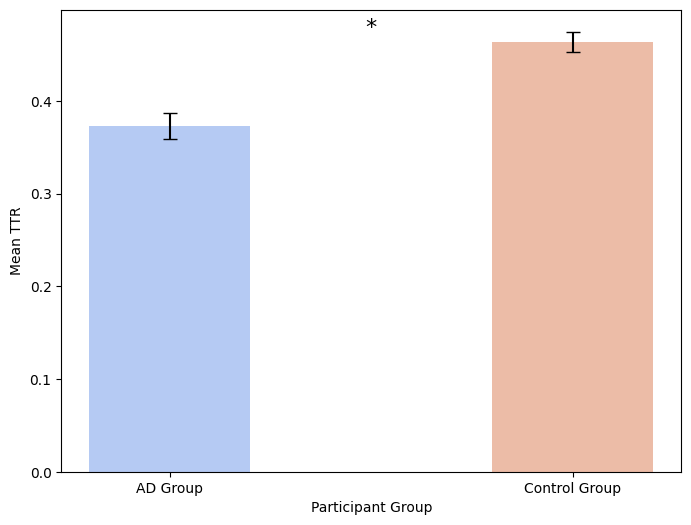

In [41]:
summary = df.groupby('basedx').agg(
    mean_TTR=('TTR', 'mean'),
    sem_TTR=('TTR', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()


plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='basedx', y='mean_TTR', data=summary, palette='coolwarm', ci=None, width=0.4)


for index, row in summary.iterrows():
    bar_plot.errorbar(
        x=index, 
        y=row['mean_TTR'], 
        yerr=row['sem_TTR'], 
        fmt='none', 
        capsize=5, 
        color='black'
    )

plt.xlabel('Participant Group')
plt.ylabel('Mean TTR')
plt.xticks([0, 1], ['AD Group', 'Control Group'])


p_value = 0.04
if p_value < 0.05:
    ylim = plt.gca().get_ylim()
    offset = 0.06 * (ylim[1] - ylim[0])
    center_x = (0 + 1) / 2  
    plt.text(center_x, ylim[1] - offset, '*', ha='center', va='bottom', fontsize=16)

plt.show()


In [42]:
file_path = 'AlzheimersSpeaks_.csv'
df.to_csv(file_path, index=False)